In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set up the game.

Define the rank and suit of a card.

In [2]:
import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

Define a card and a deck.

Implement shuffle, peek, & deal functions for the deck.

In [3]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

# Set up Blackjack

### Define logic for evaluating the value of the dealer's hand.

Trickiest part is defining the logic for Aces.

_Dealer Logic will not change much! They must follow a set, predictable course of action._

In [4]:
# This follows the same, official rules every time.
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the 
        # dealer's hand value closer to the [17, 21] range
        
        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17. 
        
        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for evaluating the value of the player's hand.

Trickiest part is defining the logic for Aces. This logic can be implemented in different ways. I opted for an approach that tries to use an Ace as an 11 whenever possible, and only uses the Ace as a 1 when the alternative would make the player bust.

In [5]:
def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for the dealer's turn.

This will not change much since the dealer has to follow a defined protocol when making their moves.

In [6]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

### Main Blackjack play_game() function.

Can use higher-order functions functionality to pick which player policy to use.

In [7]:
def play_game(player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        # The current policy does not care about dealer's upcard.
        #dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= 100
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += 100
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += 100
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= 100
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += 100
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= 100
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns net gains/losses of playing
    return player_cash - start_cash

# Simulate Discrete Policy + Graph Results

Discrete Policy:  
If hand >= 18: player stands.  
Else: Player hits.

**Implement Discrete Policy by defining what player should do on their turn.**

In [8]:
def discrete_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Discrete Policy
    # If hand >= 18, stand. Otherwise, hit.
    while player_value < 18:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

## Run 100,000 games with just 1 round in each to approximate average gain/loss per round.

**Run Simulations.**

In [9]:
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(discrete_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

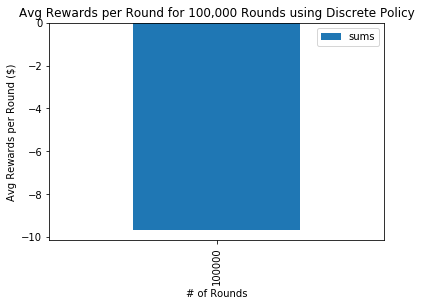

In [10]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Discrete Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Discrete Policy")

plt.show()

# Simulate Stochastic Policy + Graph Results

Stochastic Policy:  
If hand >= 18: 80% player stands, 20% player hits  
Else: 80% player hits, 20% player stands.

**Implement Stochastic Policy by defining what player should do on their turn.**

In [11]:
def stochastic_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Stochastic Policy
    # If hand >= 18: 80% Stand, 20% Hit
    # Else: 80% Hit, 20% Stand
    
    stand = False
    while player_value < 18 and stand == False:
        percent = random.randint(1, 10)
        if percent <= 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)
        else:
            # stand
            stand = True
    
    if stand:
        return player_value, player_hand, deck
    
    # player_value is now >= 18.
    if player_value < 21:
        percent = random.randint(1, 10)
        if percent > 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)        
            
        # else: Do nothing, stand.
    # else: player_value is 21 or higher, so we must stand in both cases.
    
    return player_value, player_hand, deck

## Run 100,000 games with just 1 round in each to approximate average gain/loss per round.

**Run Simulations.**

In [12]:
results = {}

num_rds = 1
num_games = 100000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(stochastic_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

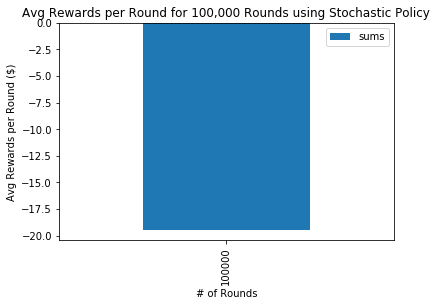

In [13]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Stochastic Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 100,000 Rounds using Stochastic Policy")

plt.show()

## Discrete Policy vs Stochastic Policy

By comparing the charts for these two policies, we can hypothesize that the Discrete Policy is a better approach to Blackjack than Stochastic Policy

The graph for the Stochastic Policy shows that as the # of rounds per game increase, the net average rewards decline at a faster rate than that of the Discrete Policy. However, this is not a very reliable metric/visualization.

The second pair of graphs that determine average rewards per round are much more insightful. The average result for any given round of Blackjack using Discrete Policy is about -\\$10. That value is about -\\$20 when using Stochastic Policy. Both strategies yield negative returns, meaning that a Blackjack player will only lose money in the long run by using either of these strategies.

-\\$10 rewards for Discrete Policy means that the casino has an edge of about 10% when a player uses this strategy. This is because the max that a player can gain/lose in any given round in the current Blackjack environment is \\$100. So, -\\$10 rewards in the context of a max gain/loss of \\$100 is a 10% disadvantage. This means that Stochastic Policy yields a 20% disadvantage for the player. My goal is to employ Reinforcement Learning and Monte Carlo approaches to train my Blackjack agent to learn a policy that (hopefully) yields a positive edge for the player. Any % above 0% will suffice to guarantee net gains in the long run.

I believe this discrepancy between Discrete Policy and Stochastic Policy is caused by the way the policies are defined. The Stochastic Policy is essentially a worse variation of the Discrete Policy. The Stochastic Policy introduces a 20% chance to make an ill-advised decision in 2 binary states. These binary states are: the player's hand value is >= 18 and the player's hand value is < 18. 

Standing when hand value >= 18 and hitting when hand value < 18 seem to be reasonably safe ways to play Blackjack. This is how Discrete Policy is defined. Although this policy is still very bad in a larger scope, it is understandable how Stochastic Policy makes Discrete Policy even worse. Adding a 20% chance to hit when hand value >= 18 seems to open the strategy up to more unneccesary losses in the long run. The same is also true of adding a 20% chance to stand when hand value < 18.

For example, it is understandable to add the 20% chance to stand for hand values between 14-18. However, this 20% stand possibility also exists for all hand values below 14, which does not make much sense. Overall, the few advantages gained in the 14-18 hand value range do not outweigh the disastrous consequences on all hand values below 14.

## Simulate Using Edward O. Thorpe's Basic Strategy

In the 1960s, mathematician Edward Thorpe published a paper and book on "Beating the Dealer". He devised the policy chart below that simplifies the process of when to hit/stand/double/split based on the player's hand and the dealer's upcard. We can expect to see a 0.44% edge for the casino with Thorpe's "Basic" Strategy chart, which is much better than the Discrete Policy.

In Part 3, we will see that the AI organically approximates its policy to something very similar to Thorpe's strategy. It is very impressive that Thorpe derived his strategy without modern tools and technologies.

[Edward Thorpe's Basic Strategy Chart](http://www.chasingthefrog.com/reelfaces/21basicstrategy.php#:~:text=In%20his%201960s%20book%20Beat,following%20version%20of%20Edward%20O.)

### Implement Edward Thorpe's Basic Strategy

In [14]:
# 0 -> stand
# 1 -> hit
ss_chart = {
    12 : [1,1,0,0,0,1,1,1,1,1],
    13 : [0,0,0,0,0,1,1,1,1,1],
    14 : [0,0,0,0,0,1,1,1,1,1],
    15 : [0,0,0,0,0,1,1,1,1,1],
    16 : [0,0,0,0,0,1,1,1,1,1]
}

def basic_strategy_policy(player_hand, dealer_upcard, deck):
    player_value = player_eval(player_hand)
    
    while player_value < 17:
        if player_value < 12: # Always hit if < 12
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)
        else: # use ss_chart for >= 12 and < 17
            action = None
            if dealer_upcard.rank == "ace":
                action = ss_chart[player_value][-1]
            else:
                action = ss_chart[player_value][dealer_upcard.value - 2]
                
            if action == 0: # stand
                return player_value, player_hand, deck
            else: # action == 1, which is hit
                # hit
                player_hand.append(deck.deal())
                player_value = player_eval(player_hand)
        
    # Always stand if >= 17 and <= 21.
    return player_value, player_hand, deck

**Tweak play_game() to pass dealer_upcard into the player_policy.**

Since Thorpe's strategy considers the dealer's upcard, we need to store and use this value when consulting `basic_strategy_policy()` for the next action.

In [15]:
def play_game(player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to be negative when actually training, so that agent tries to win more than tie.)
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, dealer_upcard, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= 100
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += 100
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += 100
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= 100
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += 100
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= 100
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns net gains/losses of playing
    return player_cash - start_cash

**Run Simple Simulations.**

Don't make x-axis # of rounds. Don't vary the number of rounds. The previous simulation shows that there aren't any reliable trends that can be observed by splitting it up by # of rounds.

Focus more on just repeatedly running a game with a high, set # of rounds to get towards a average reward.

Here, we opt for 10,000 games of 1 round each to see the average reward per round.

In [16]:
results = {}
num_rds = 1
num_games = 10000

for i in range(num_games):
    net_avg += play_game(basic_strategy_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

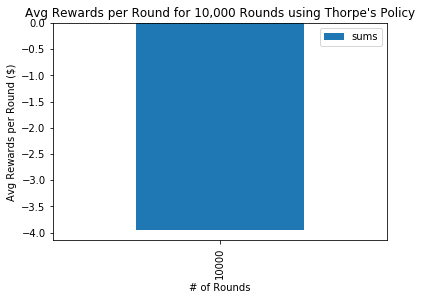

In [17]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Thorpe's Basic Strategy Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 10,000 Rounds using Thorpe's Policy")

plt.show()

### Analysis/Comments on Simulating Edward Thorpe's Basic Strategy

The chart above shows that this simulation did not yield the actual 0.44\% casino edge that is expected of Edward Thorpe's Basic Strategy chart. Instead, my simulation yielded approximately a 4\% casino edge. Although this simulation missed the expected 0.44\%, this is still a vast improvement from my previous best policy (Discrete Policy). 

This also motivates me to figure out where this simulation approach went wrong, and how I can improve to get closer to the goal of 0.44%. I think the main reason that my simulations are running sub-optimally is due to the numerous simplifications I made to my version of Blackjack compared to the real game. As a result, there are many nuances of Edward Thorpe's Basic Strategy that are left out. For example, I did not factor in any of Edward Thorpe's logic for playing with Aces in your hand. I just considered the Ace being treated as 1s or 11s and following the simplified chart logic for whatever the hand total happened to be. 

Additionally, I did not give the player the option to double their bet in my version of Blackjack. Edward Thorpe's Basic Strategy does instruct the player to double-down on their bet in particularly high-value positions. If my simulation were to account for this, I think there would more instances where my player gained a larger reward than they would have in my simplified model, which would have yielded a lower casino edge as a result.

Also, I did not explore any of the nuances regarding splitting your Blackjack hand when having a pair of the same rank.

## Define the OpenAI Gym Environment for Blackjack

In [18]:
import random
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

INITIAL_BALANCE = 1000
NUM_DECKS = 6

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        
        # Initialize the blackjack deck.
        self.bj_deck = Deck(NUM_DECKS)
        
        self.player_hand = []
        self.dealer_hand = []
        
        self.reward_options = {"lose":-100, "tie":0, "win":100}
        
        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)
        
        '''
        First element of tuple is the range of possible hand values for the player. (3 through 20)
        This is the possible range of values that the player will actually have to make a decision for.
        Any player hand value 21 or above already has automatic valuations, and needs no input from an
        AI Agent. 
        
        However, we also need to add all the hand values that the agent could possibly end up in when
        they bust. Maybe the agent can glean some correlations based on what hand value they bust at,
        so this should be in the observation space. Also, the layout of OpenAI Gym environment class
        makes us have to include the bust-value in the step() function because we need to return that
        done is true alongside the final obs, which is the bust-value.
        '''
        
        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))
        
        self.done = False
        
    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.bj_deck.deal())
            
        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = player_eval(self.player_hand)
    
    def step(self, action):
        self._take_action(action)
        
        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21
        
        # rewards are 0 when the player hits and is still below 21, and they
        # keep playing.
        rewards = 0
        
        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: # above 21, player loses automatically.
                rewards = self.reward_options["lose"]
            elif self.player_value == 21: # blackjack! Player wins automatically.
                rewards = self.reward_options["win"]
            else:
                ## Begin dealer turn phase.

                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck)

                ## End of dealer turn phase

                #------------------------------------------------------------#

                ## Final Compare

                if dealer_value > 21: # dealer above 21, player wins automatically
                    rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        rewards = self.reward_options["lose"]
                    else:
                        rewards = self.reward_options["tie"]
        
        self.balance += rewards
        
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
        
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs, rewards, self.done, {}
    
    def reset(self): # resets game to an initial state
        # Add the player and dealer cards back into the deck.
        self.bj_deck.cards += self.player_hand + self.dealer_hand

        # Shuffle before beginning. Only shuffle once before the start of each game.
        self.bj_deck.shuffle()
         
        self.balance = INITIAL_BALANCE
        
        self.done = False
        
        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]
        
        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
            
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs
    
    def render(self, mode='human', close=False):
        # convert the player hand into a format that is
        # easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.rank)
            
        # re-calculate the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])
        
        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')
        
        print()

## Test the OpenAI Gym Blackjack Environment

In [23]:
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 1000

for _ in range(NUM_EPISODES):
    env.reset()
    
    episode_reward = 0
    while env.done == False:
        action = env.action_space.sample()

        new_state, reward, done, desc = env.step(action)
        
        episode_reward += reward
        
    total_rewards += episode_reward
        
avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)

-31.6


# Implement First-Visit Monte Carlo Algorithm

In [10]:
import numpy as np
import random

### run_mc() to run the First-Visit Monte Carlo Algorithm

This function initializes the key variables for the algorithm and runs the learning algorithm for the AI agent for `num_episodes` episodes. An episode is a simulation of one game of Blackjack using the OpenAI Gym environment defined above.  

`Q`, or the Q-table, is a 2-D list in which the rows are the different possible states and the columns are the different possible actions for each state. The values stores in each cell refer to the value, or Q-value, of selecting some action (the column index) given some state (the row index). These Q-values start at 0 for every state-action pair, and are updated by the update_Q() function after each episode to reflect the rewards received in an episode where the state-action pair occured. All Q-values initially start at 0.  

`prob`, or the prob table, has the same structure as `Q`, but the cell values refer to the probability of selecting some action (the column index) given some state (the row index). These probabilities are updated by the update_prob() function after the Q-values are updated after each episode. All action probabilties start at 0.5 (or 50%).  

`alpha` defines the weight given to each new change in Q-value within the update_Q() function. A smaller `alpha` means that a new reward logged in an episode for some state-action pair has less impact on the current Q-value for that state-action pair. The converse is also true. Therefore, `alpha` essentially defines how fast the AI agent learns.  

`epsilon` defines the weight given to each new change in the action probabilities within the update_prob() function. A larger `epsilon` reduces the % amount by which an action probability is changed after some changes in Q-values. The converse is also true. An `epsilon` of 1 means that no change will occur in the action probability, regardless of the magnitude of changes in Q-values.  

`epsilon` is decayed by the `decay` value after every episode. The lowest value `epsilon` can reach is `epsilon_min`.  

`gamma` is the rate used to discount future rewards yielded by a certain state-action pair in the episode. Since a round (or episode) of Blackjack can have more than 1 decision made, there can be numerous state-action pairs that are seen in one episode. However, only the final decision (or state-action pair) yields an immediate reward from the environment. All previous state-action pairs had no rewards. So, the final reward must be used to modify the Q-values of the earlier state-action pairs. Since the final reward was only partially made possible by the earlier state-action pairs, the final reward is discounted using `gamma` to account for this.  

Once these important variables are defined, this function runs the First-Visit Monte Carlo algorithm for the Blackjack environment.

The function runs `num_episodes` episodes.  

In each episode, `epsilon` is first decayed by the `decay` rate.  

Then, the game of Blackjack is played out through the `play_game()` function. This function returns a list of the state-action-reward tuples that occured during the game. These tuples represent the actions the AI agent had to take given some state, and the rewards that resulted.  

These tuples are used to modify the Q-values in `Q` through the `update_Q()` function.  

Then, the tuples are used to modify the probability distributions in `prob` of the two actions (hit or stand) for any states that were encountered in the episode. This is done through the `update_prob()` function.

After this process is done for each episode, the function returns the modified `Q` and `prob` tables. These tables are an imprint of the learning that has taken place by the AI agent through the First-Visit Monte Carlo algorithm.

In [11]:
def run_mc(env, num_episodes):
    '''
    observation_space[0] is the 18 possible player values. (3 through 20)
    observation_space[1] is the 10 possible dealer upcards. (2 through 11)

    Combining these together yields all possible states.

    Multiplying this with hit/stand yields all possible state/action pairs.

    This is the Q map.
    '''
    Q = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16)


    # This map contains the probability distributions for each action (hit or stand) given a state.
    # The state (combo of player hand value and dealer upcard value) index in this array yields a 2-element array
    # The 0th index of this 2-element array refers to the probability of "hit", and the 1st index is the probability of "stand"
    prob = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16) + 0.5

    # The learning rate. Very small to avoid making quick, large changes in our policy.
    alpha = 0.001

    epsilon = 1
    
    # The rate by which epsilon will decay over time.
    # Since the probability we take the option with the highest Q-value is 1-epsilon + probability,
    # this decay will make sure we are the taking the better option more often in the longrun.
    # This allows the algorithm to explore in the early stages, and exploit in the later stages.
    decay = 0.9999
    
    # The lowest value that epsilon can go to.
    # Although the decay seems slow, it actually grows exponentially, and this is magnified when
    # running thousands of episodes.
    epsilon_min = 0.9

    # may have to be tweaked later.
    gamma = 0.8
    
    for _ in range(num_episodes):
        episode = play_game(env, Q, prob)
        
        epsilon = max(epsilon * decay, epsilon_min)
        
        Q = update_Q(env, episode, Q, alpha, gamma)
        prob = update_prob(env, episode, Q, prob, epsilon)
        
    return Q, prob

### play_game() function

Simulates playing one round (or episode) or Blackjack.

First, use env.reset() to set up a new round of Blackjack.

If the player is already dealt a Blackjack by luck, then this episode is just scrapped. There is nothing the AI agent can learn from this episode since it did not have to make any decisions.

Otherwise, the AI agent finds the best action available given the current state of the game and its knowledge so far. This knowledge is stored in the `Q`-table defined in the run_mc() function above. Then, the AI agent retrieves the probability that it should take this action from the `prob` table. The AI agent applies this probability and chooses its action given this state. The action is sent to the environment, and a reward is returned from the environment. The state-action-reward sequence that just occured is stored in `episode` as a tuple. This process is repeated until the current episode is over. Each episode will roughly yield 1-3 tuples in `episode` since Blackjack rounds are usually resolved after 1-3 decisions by the player.

The Q-values in the `Q`-table associated with each state-action pair that was seen in this episode will be updated after this episode based on the state-action-reward tuples returned by this function. Then, the corresponding probabilities in `prob` are also modified to reflect this change in Q-values. 

In [12]:
def play_game(env, Q, prob):
    # Can contain numerous state->action->reward tuples because a round of 
    # Blackjack is not always resolved in one turn.
    # However, there will be no state that has a player hand value that exceeds 20, since only initial
    # states BEFORE actions are made are used when storing state->action->reward tuples.
    episode = []
    
    state = env.reset()
    
    while env.done == False:
        if state[0] == 19: #Player was dealt Blackjack, player_value already subtracted by 2 to get state[0]
            # don't do any episode analysis for this episode. This is a useless episode.
            next_state, reward, env.done, info = env.step(1) # doesn't matter what action is taken.
        else:
            # Get the index in Q that corresponds to the current state
            Q_state_index = get_Q_state_index(state)
            
            # Use the index to get the possible actions, and use np.argmax()
            # to get the index of the action that has the highest current Q
            # value. Index 0 is hit, index 1 is stand.
            best_action = np.argmax(Q[Q_state_index])
            
            # Go to the prob table to retrieve the probability of this action.
            # This uses the same Q_state_index used for finding the state index
            # of the Q-array.
            prob_of_best_action = get_prob_of_best_action(env, state, Q, prob)

            action_to_take = None

            if random.uniform(0,1) < prob_of_best_action: # Take the best action
                action_to_take = best_action
            else: # Take the other action
                action_to_take = 1 if best_action == 0 else 0
            
            # The agent does the action, and we get the next state, the rewards,
            # and whether the game is now done.
            next_state, reward, env.done, info = env.step(action_to_take)
            
            # We now have a state->action->reward sequence we can log
            # in `episode`
            episode.append((state, action_to_take, reward))
            
            # update the state for the next decision made by the agent.
            state = next_state
        
    return episode

### update_Q() function

This function iterates through the state-action-reward tuples in `episode` and updates the Q-values of the corresponding state-action pairs in `Q`.  



In [13]:
def update_Q(env, episode, Q, alpha, gamma):
    '''
    THIS IS WHERE THE ALGORITHM HINGES ON BEING FIRST VISIT OR EVERY VISIT.
    I AM GOING TO USE FIRST-VISIT, AND HERE'S WHY.
    
    If you want first-visit, you need to use the cumulative reward of the entire
    episode when updating a Q-value for ALL of the state/action pairs in the
    episode, even the first state/action pair. In this algorithm, an episode
    is a round of Blackjack. Although the bulk of the reward may come from the
    2nd or 3rd decision, deciding to hit on the 1st decision is what enabled
    the future situations to even occur, so it is important to include the
    entire cumulative reward. We can reduce the impact of the rewards of the
    future decisions by lowering gamma, which will lower the G value for our
    early state/action pair in which we hit and did not get any immediate rewards.
    This will make our agent consider future rewards, and not just look at 
    each state in isolation despite having hit previously.
     
    If you want Every-Visit MC, do not use the cumulative rewards when updating Q-values,
    and just use the immediate reward in this episode for each state/action pair.
    '''
    step = 0
    for state, action, reward in episode:
        # calculate the cumulative reward of taking this action in this state.
        # Start from the immediate rewards, and use all the rewards from the
        # subsequent states. Do not use rewards from previous states.
        total_reward = 0
        gamma_exp = 0
        for curr_step in range(step, len(episode)):
            curr_reward = episode[curr_step][2]
            total_reward += (gamma ** gamma_exp) * curr_reward
            gamma_exp += 1
        
        # Update the Q-value
        Q_state_index = get_Q_state_index(state)
        curr_Q_value = Q[Q_state_index][action]
        Q[Q_state_index][action] = curr_Q_value + alpha * (total_reward - curr_Q_value)
        
        # update step to start further down the episode next time.
        step += 1
        
        
    return Q

### update_prob() function

In [14]:
def update_prob(env, episode, Q, prob, epsilon):
    for state, action, reward in episode:
        # Update the probabilities of the actions that can be taken given the current
        # state. The goal is that the new update in Q has changed what the best action
        # is, and epsilon will be used to create a small increase in the probability
        # that the new, better action is chosen.
        prob = update_prob_of_best_action(env, state, Q, prob, epsilon)
        
    return prob

### A function to map a state from the Blackjack environment to the proper index in `Q` and `prob` tables.

In [15]:
# Given a state, derive the corresponding index in the Q-array.
# The state is a player hand value + dealer upcard pair,
# so a "hashing" formula must be used to allocate the
# indices of the Q-array properly.
def get_Q_state_index(state):
    # the player value is already subtracted by 1 in the env when it returns the state.
    # subtract by 1 again to fit with the array indexing that starts at 0
    initial_player_value = state[0] - 1
    # the upcard value is already subtracted by 1 in the env when it returns the state.
    # dealer_upcard will be subtracted by 1 to fit with the array indexing that starts at 0
    dealer_upcard = state[1] - 1

    return (env.observation_space[1].n * (initial_player_value)) + (dealer_upcard)

### Functions to get and update the probability of taking the best action for a given state.

In [16]:
def get_prob_of_best_action(env, state, Q, prob):
    # Use the mapping function to figure out which index of Q corresponds to 
    # the player hand value + dealer upcard value that defines each state.
    Q_state_index = get_Q_state_index(state)
    
    # Use this index in the Q 2-D array to get a 2-element array that yield
    # the current Q-values for hitting (index 0) and standing (index 1) in this state.
    # Use the np.argmax() function to find the index of the action that yields the
    # rewards i.e. the best action we are looking for.
    best_action = np.argmax(Q[Q_state_index])
    
    # Retrieve the probability of the best action using the 
    # state/action pair as indices for the `prob` array,
    # which stores the probability of taking an action (hit or stand)
    # for a given state/action pair.
    return prob[Q_state_index][best_action]
    
def update_prob_of_best_action(env, state, Q, prob, epsilon):

    Q_state_index = get_Q_state_index(state)
    
    best_action = np.argmax(Q[Q_state_index])
    
    # Slightly alter the probability of this best action being taken by using epsilon
    # Epsilon starts at 1.0, and slowly decays over time.
    # Therefore, as per the equation below, the AI agent will use the probability listed 
    # for the best action in the `prob` array during the beginning of the algorithm.
    # As time goes on, the likelihood that the best action is taken is increased from
    # what is listed in the `prob` array.
    # This allows for exploration of other moves in the beginning of the algorithm,
    # but exploitation later for a greater reward.
    #prob[Q_state_index][best_action] = prob[Q_state_index][best_action] + ((1 - epsilon) * (1 - prob[Q_state_index][best_action]))
    prob[Q_state_index][best_action] = min(1, prob[Q_state_index][best_action] + 1 - epsilon)
    
    other_action = 1 if best_action == 0 else 0
    prob[Q_state_index][other_action] = 1 - prob[Q_state_index][best_action]
    
    return prob

## Run First-Visit Monte Carlo Reinforcement Learning Algorithm

In [26]:
import time
env = BlackjackEnv()

start_time = time.time()
new_Q, new_prob = run_mc(env, 1000000)
end_time = time.time()

print("Total Time for Learning: " + str(end_time - start_time))

Total Time for Learning: 247.80405807495117


## best_policy() function
This function takes the new_Q Q-table returned by the First Visit MC algorithm and keeps only the action that yields the highest value for a given state.  

This is represented in three different ways: binary, string, and colors.  
0 is hit and 1 is stand in the binary representation of the results.  
H is hit and S is stand in the binary representation of the results.  
Green is hit and Red is stand in the binary representation of the results.  

In [27]:
def best_policy(Q):
    best_policy_binary = []
    best_policy_string = []
    best_policy_colors = []
    for i in range(len(Q)):
        best_policy_binary.append(np.argmax(Q[i]))
        best_policy_string.append("H" if np.argmax(Q[i]) == 0 else "S")
        best_policy_colors.append("g" if np.argmax(Q[i]) == 0 else "r")
        
    return best_policy_binary, best_policy_string, best_policy_colors

## Create DataFrame w/ Player Value as Rows & Dealer Upcard as Columns

In [28]:
import pandas as pd
new_Q_binary, new_Q_string, new_Q_colors = best_policy(new_Q)

df = pd.DataFrame(columns = range(2, 12))

color_df = pd.DataFrame(columns = range(2, 12))

for s in range(3, 21): # possible player values in the range 3 to 20
    start = env.observation_space[1].n * (s-3)
    end = start + 10
    df.loc[s]=(new_Q_string[start:end])
    color_df.loc[s]=(new_Q_colors[start:end])

## Create Chart Graphic for the Results

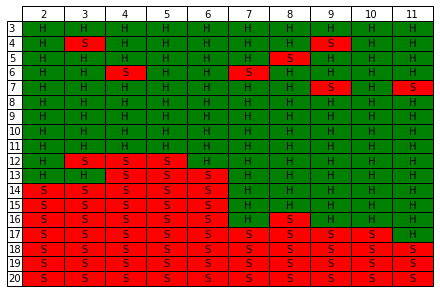

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.set_axis_off()
ax.axis('tight')

ax.table(cellText=df.values, cellColours=color_df.values, cellLoc="center", rowLabels=df.index, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()

## Test Best Policy on New Episodes

In [32]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 100000

for _ in range(NUM_EPISODES):
    state = env.reset()

    while env.done == False:
        if state[0] == 19: # Player was dealt Blackjack
            next_state, reward, env.done, info = env.step(1) # doesn't matter what action is taken.
            # don't do any episode analysis for this episode. This is a useless episode.
            total_rewards += reward
        else:
            Q_index = get_Q_state_index(state)
            action = new_Q_binary[Q_index]

            new_state, reward, done, desc = env.step(action)
            state = new_state
            total_rewards += reward
        
avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)

-4.757
